## Correlation Analysis Workflow with <i>Active</i> Provenance in dispel4py:



### Correlation Analysis Workflow (CAW): Description and Components
<br/>

This page implements a workflow that analyses the correlation between a configurable number of variables. It produces a correlation matrix and a graph given a minimum correlation threshold. Eventually, it finds the graph max cliques, which show all the variables that are together correlated above the threshold. The workflow can run over multipe iterations, with parametrisable sampling-rate and length of the variable's batches.

The workflow specification and its parametrisation are inspired by the following research paper:
https://www.cs.ubc.ca/~hoos/Publ/RosEtAl07.pdf

#### Components
<br/>

<li>1 -   <b>Start</b>: Root node of the graph. It broadcasts the <i>sampling-iteration</i> number to the <b>Source</b> components </li>
<li>2 -   <b>Source</b>: Produces random numbers from 0,100 at a specified sampling-rate and organises them in batches</li>
<li>3 -   <b>CorrCoef</b>: Calculates the Pearson's correlation coefficient of the batches coming from two sourcs</li>
<li>4 -   <b>CorrMatrix</b>: Produces and visualises the correlation matrix for all sources, for each <i>sampling-iteration</i></li>
<li>5 -   <b>MaxClique</b>: Transforms the correlation matrix into a graph, according to a correlation minimum threshold and computes the graph’s max cliques</li>


<br/>


In [1]:
%matplotlib inline


from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
from dispel4py.new.processor  import *
import time
import random
import numpy
import traceback 
from dispel4py.base import create_iterative_chain, GenericPE, ConsumerPE, IterativePE, SimpleFunctionPE
from dispel4py.new.simple_process import process_and_return
from dispel4py.visualisation import display
import IPython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
import networkx as nx
from itertools import combinations

sns.set(style="white")


class Start(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        #self.prov_cluster="myne"
    
    def _process(self,inputs):
        print "DA"
        if 'iterations' in inputs:
            inp=inputs['iterations']
             
            self.write('output',inp,metadata={'iterations':inp})
            
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'

class Source(GenericPE):

    def __init__(self,sr,index,batchsize):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        self.sr=sr
        self.var_index=index
        self.batchsize=batchsize
        #self.prov_cluster="myne"
         
        self.parameters={'sampling_rate':sr,'batchsize':batchsize}
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
         
        if 'iterations' in inputs:
            iteration=inputs['iterations'][0]
        
        
        batch=[]
        it=1
        
        #Streams out values at 1/self.sr sampling rate, until iteration>0
        while (it<=iteration):
            while (len(batch)<self.batchsize):
                val=random.uniform(0,100)
                time.sleep(1/self.sr)
                batch.append(val)
                
            self.write('output',batch,metadata={'var':self.var_index,'iteration':it,'batch':batch})
             
            batch=[]
            it+=1
        

class AvgDetect(GenericPE):

    def __init__(self,period):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('avg')
        self._add_output('detect')
        self.avg=None
        self.summ=0
        self.count=0
        self.period=period
        self.parameters={"period":period}
        
        
                
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
         
        if 'input' in inputs:
            val=inputs['input'][0]
            self.summ+=val
            self.count+=1
        
            if self.avg!=None and val>self.avg:
                self.write('detect',val,metadata={'detection':val})
                print "detect: "+str(val)
        
            if self.count==self.period:
                self.avg=self.summ/self.period
                self.write('avg',self.avg,metadata={'average':self.avg})
                print "avg: "+str(self.avg)
                self.count=0
                self.summ=0
            
        
        
         
       
        
      




### Definition of the workflow



We define now the workflow and its parameterisation. 





In [2]:

variables_number=15
sampling_rate=100
batch_size=1
iterations=15
period=3

input_data = {"Start": [{"iterations": [iterations]}]}
      
# Instantiates the Workflow Components  
# and generates the graph based on parameters

def createWf():
    graph = WorkflowGraph()
    start=Start()
    detect= AvgDetect(period)

    
    
   
    stock=['hft:NASDAQ','hft:MIBTEL','hft:DOWJ']
    source = Source(sampling_rate,0,batch_size)
    
   
    graph.connect(start,'output',source,'iterations')
    graph.connect(source,'output',detect,'input')
    
    
        
  
    return graph
        



### Execution without provenance
The following script executes the workflow in single-process mode with no provenance
<br/>

Preparing for: 15 projections


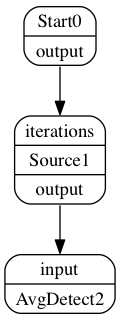

DA
avg: 39.3943106047
detect: 49.3672549031
detect: 81.2211774355
avg: 53.6545610281
detect: 76.9725443002
avg: 51.8002432756
detect: 74.8316591276
detect: 96.1370396405
avg: 73.9248817778
detect: 90.7444171977
avg: 65.9530657435
SimplePE: Processed 1 iteration.
ELAPSED TIME: 0.00175094604492


In [3]:
 

#Launch in simple process
print ("Preparing for: "+str(iterations)+" projections" )
graph=createWf()
display(graph)
start_time = time.time()

#Uncommend to run the workflow without provenance
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))


## Provenance Types

Type for contextual metadata: 

<b>StockType</b>: used to define the metadata properties that should be extracted from the data produced in output on a specific port: the <i>extractItemMetadata</i> produces the dictionary (list of dictionaries) to be stored as contextual metadata for each element of the computation. 


Types capturing provenance patterns:

<b>ASTGrouped:</b> (Accumulate State Trace Grouped) this type manages a stateful operator with grouping rules.


<b>IntermediateStatefulOut</b>: stateful component which produces distinct but interdependent output.



In [9]:



class StockType(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
        self.streammeta=[]
        self.count=1
        self.addNamespacePrefix("hft","http://hft.eu/ns/#")
    
    
    
        def makeUniqueId(self,**kwargs):

            #produce the id
            id=str(uuid.uuid1())

            #Store here the id into the data (type specific):
            if 'data' in kwargs:
                data=kwargs['data']

            #Return
            return id
    
    def extractItemMetadata(self,data,port):
        try:
            metadata=None
            self.embed=True
            self.streammeta.append({'val':str(data)})
             
            if (self.count%1==0):
                
                metadata=deepcopy(self.streammeta)
                self.provon=True
                self.streammeta=[]
            else:
                self.provon=False
            
            self.count+=1
            return metadata
                
                 

        except Exception, err:
            self.log("Applying default metadata extraction:"+str(traceback.format_exc()))
            self.error=self.error+"Extract Metadata error: "+str(traceback.format_exc())
            return super(StockType, self).extractItemMetadata(data,port);
            

            
class ASTGrouped(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
        
  
    def apply_derivation_rule(self,event,voidInvocation,iport=None,oport=None,data=None,metadata=None):
       
         

        
        if (event=='write'):
            vv=str(abs(make_hash(tuple([self.getInputAt(port=iport,index=x) for x in self.inputconnections[iport]['grouping']]))))
            self.setStateDerivations([vv])

        if (event=='end_invocation_event' and voidInvocation==False):
             self.discardInFlow()
             self.discardState()

        if (event=='end_invocation_event' and voidInvocation==True):
            
            if data!=None:
                
                vv=str(abs(make_hash(tuple([self.getInputAt(port=iport,index=x) for x in self.inputconnections[iport]['grouping']]))))
                self.ignorePastFlow()
                self.update_prov_state(vv,data,metadata={"LOOKUP":str(vv)},dep=[vv])
                self.discardInFlow()
                self.discardState()
                

class IntermediateStatefulOut(ProvenanceType):
     
    def __init__(self):
        ProvenanceType.__init__(self)
        
    
    def apply_derivation_rule(self,event,voidInvocation,iport=None,oport=None,data=None,metadata=None):
         
        self.ignore_past_flow=False
        self.ignore_inputs=False
        self.stateful=False
        
        if (event=='write' and oport == self.STATEFUL_PORT):
            self.update_prov_state(self.STATEFUL_PORT,data,metadata=metadata)
            self.discardInFlow()

        if (event=='write' and oport != self.STATEFUL_PORT):
            self.ignorePastFlow()

   #     if (event=='end_invocation_event' and voidInvocation==False):
            
   #         self.discardInFlow()
   #         self.discardState()   
            
    


## Prepare the workfow for provenance tracking

Once the Provenance types have been defined, these are used to configure a workflow execution to comply with the desired provenance collection requirements.  Below we illustrate the framework method and the details of this approach.

<ul>

<li><b><i>configure_prov_run</i></b> With this method, the users of the workflow can prepare their run for provenance by indicating which types to apply to each component. Users can also chose where to store the metadata, locally to the file system or to a remote service. These operations can be performed in bulks, with different impacts on the overall overhead and on the experienced rapidity of the access of the lineage information. Additional details on the proposed remote provenance storage and access service will be provided in Chapter V. Finally, also general information about the attribution of the run, such as <i>username, run_id, description, workflow_name, workflow_id</i> are captured and included within the provenance traces.
</li>
<li><b><i>Selectivity-Rules (Advanced)</i></b>
Users can tune the scale of the records produced by indicating in the above method a set of <i>sel-rules</i> for every component.This functionality allows users to specify rules to control the data-driven production of the provenance declaratively. The approach takes advantage of the contextualisation applied by the provenance types, which extract domain and experimental metadata, and evaluates their value against simple <i>sel-rule</i> of this kind:
</li>
</ul>

In [10]:

#Definition of metadata driven selectivity rules

selrule1 = {"CorrCoef": { 
                         "rules":{ 
                                 "rho": {
                                            "$gt": 0 }
                                }
                        }
           }


#Excludes the start component from the trace
selrule2 = {"Start": { 
                         "rules":{ 
                                 "iterations": {
                                            "$lt": 0 }
                                }
                        }
           }


#Configuration setup of the provenance execution of the run
prov_config = {
     "provone:User": "aspinuso",
     "s-prov:description": " Periodic average detection",
     "s-prov:workflowName": "PAD",
     "s-prov:workflowType": "hft:CorrelationAnalysis",
     "s-prov:workflowId": "190341",
     "s-prov:save-mode": "service",
     "s-prov:componentsType":
     {

      "AvgDetect": {"s-prov:type": (IntermediateStatefulOut,), "s-prov:stateful-port":"avg"}
      
    },
    "s-prov:sel-rules": None
}

Change grouping implementation 
AvgDetect Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.IntermediateStatefulOut'>, <class '__main__.AvgDetect'>)
Source Original base class: (<class 'dispel4py.core.GenericPE'>,)
(<class 'dispel4py.provenance.SingleInvocationFlow'>,)
 New type: (<class 'dispel4py.provenance.SingleInvocationFlow'>, <class '__main__.Source'>)
Start Original base class: (<class 'dispel4py.core.GenericPE'>,)
(<class 'dispel4py.provenance.SingleInvocationFlow'>,)
 New type: (<class 'dispel4py.provenance.SingleInvocationFlow'>, <class '__main__.Start'>)
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
NewWorkflowRun11: BUILDING INITIAL DERIVATION
NewWorkflowRun11: STORING WORKFLOW RUN METADATA
NewWorkflowRun11: Postprocess: (200, 'OK', '{"inserts": [{"updatedExisting": false, "nModified": 0, "ok": 1.0, "upserted": "PAD_JUP_orfeus-as-9525-22a4aa70-8a93-11e8-bf3c-f45c89acf865", "n": 1}], "success": true}')
SimplePE: Processed 1 iteration.

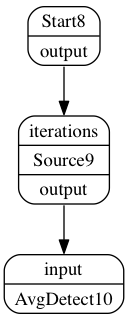

In [11]:


#Store via service
ProvenanceType.REPOS_URL='http://127.0.0.1:8082/workflowexecutions/insert'

#Export data lineage via service (REST GET Call on dataid resource /data/<id>/export)
ProvenanceType.PROV_EXPORT_URL='http://127.0.0.1:8082/workflowexecutions/'

#Store to local path
ProvenanceType.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenanceType.BULK_SIZE=20

rid=None

def createGraphWithProv():
    
    graph=createWf()
    
    # Ranomdly generated unique identifier for the current run
    rid='PAD_JUP_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:   
    #Initialise provenance storage end associate a Provenance type with specific components:
    configure_prov_run(graph,None,
                       provImpClass=(SingleInvocationFlow,),
                       username=prov_config["provone:User"],
                       runId=rid,
                       input=[{'name':'variables_number','val':variables_number},
                              {'name':'sampling_rate','val':sampling_rate},
                              {'name':'batch_size','val':batch_size},
                              {'name':'iterations','val':iterations}],
                       description=prov_config["s-prov:description"],
                       workflowName=prov_config["s-prov:workflowName"],
                       workflowType=prov_config["s-prov:workflowType"],
                       workflowId="!23123",
                       componentsType= prov_config["s-prov:componentsType"],
                       save_mode=prov_config["s-prov:save-mode"],
                       sel_rules=prov_config["s-prov:sel-rules"],
                       
                      )
    return (graph,rid)


graph,rid=createGraphWithProv()

display(graph)

### Execution with provenance
The following script executes the workflow in single-process mode
<br/>

In [12]:
#Launch in simple process
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))

Start8: BUILDING INITIAL DERIVATION
DA
avg: 51.5285209544
detect: 84.5286734397
avg: 42.9107024829
detect: 75.5835946375
detect: 91.0884443067
avg: 61.6916738409
detect: 83.4186496445
detect: 77.4616959738
avg: 66.8080221504
avg: 48.8344363153
Start8: Postprocess: (200, 'OK', '{"inserts": ["Start8_write_orfeus-as-9525-23515807-8a93-11e8-88ae-f45c89acf865"], "success": true}')
Source9: Postprocess: (200, 'OK', '{"inserts": ["Source9_write_orfeus-as-9525-23517517-8a93-11e8-a052-f45c89acf865", "Source9_write_orfeus-as-9525-235191b0-8a93-11e8-8fdd-f45c89acf865", "Source9_write_orfeus-as-9525-2351a42b-8a93-11e8-823e-f45c89acf865", "Source9_write_orfeus-as-9525-2351c46e-8a93-11e8-9278-f45c89acf865", "Source9_write_orfeus-as-9525-2351dceb-8a93-11e8-bb75-f45c89acf865", "Source9_write_orfeus-as-9525-2351f61c-8a93-11e8-9d37-f45c89acf865", "Source9_write_orfeus-as-9525-2352088f-8a93-11e8-93ec-f45c89acf865", "Source9_write_orfeus-as-9525-23522254-8a93-11e8-938a-f45c89acf865", "Source9_write_orfeus

### Provenance trace extraction from S-ProvFlow

The following instructions connect to the online S-ProvFlow WEB-API and downloads the PROV trace for a single runid
<br/>

In [8]:

print("Extract Trace for run id "+rid)

expurl = urlparse(ProvenanceType.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
url= "http://"+expurl.netloc+expurl.path+rid+"/export?format=rdf"
print url
connection.request(
                "GET", url)
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
provdoc = response.read()
#Uncomment this line to visualise the PROV XML
print('PROV : '+str(provdoc))

Extract Trace for run id PAD_JUP_orfeus-as-9525-5035edee-8a7e-11e8-8cab-f45c89acf865
http://127.0.0.1:8082/workflowexecutions/PAD_JUP_orfeus-as-9525-5035edee-8a7e-11e8-8cab-f45c89acf865/export?format=rdf
progress: (200, 'OK')
PROV : @prefix dcterms: <http://purl.org/dc/terms/> .
@prefix knmi: <http://knmi.nl/ns/#> .
@prefix ns1: <http://www.w3.org/2006/vcard/> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix s-prov: <http://s-prov/ns/#> .
@prefix var: <http://schema.org#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

{
    var:orfeus-as-2805-546619fd-8a7e-11e8-97ef-f45c89acf865 a s-prov:WFExecutioinBundle,
            prov:Entity ;
        prov:wasAttributedTo knmi:ag_anonymous .

    knmi:ag_anonymous a prov:Agent ;
        dcterms:creator "anonymous"^^

### 2.3 - Visualise Provenance Trace

Read the if of the output to locate the provenance trace on the remote service

#### 2.3.1 Visualise in S-ProvFlow

The following link opens a local installation of the S-ProvFlow System GUI. Enter your username and open the run with the RunID shown above

http://127.0.0.1:8180/provenance-explorer/html/view.jsp

In [ ]:
import prov
import io
import StringIO
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provTo(xml,output_f):
     
    xml_doc = StringIO.StringIO()
    xml_doc.write(str(xml))
    xml_doc.seek(0, 0)
    #print xml_doc
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    return dot.create(format=output_f)


expurl = urlparse(ProvenanceType.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
url= "http://"+expurl.netloc+expurl.path+rid+"/export?all=true"
print url
connection.request(
                "GET", url)
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
provdoc = response.read()
png_content=provTo(provdoc,"png")

with open("PROV.png","w+") as text_file:
    text_file.write(str(png_content))

from IPython.display import Image
Image("PROV.png")

## Developing Provenance Sensors

The Class below show a sample <i>ProvenanceSensorToService</i> and a slightlty more advanced one that allows for feedback.

### ProvenanceSensorToService

Recieves traces from the PEs and sends them out to an exteranal provenance store.



In [ ]:

class ProvenanceSensorToService(ProvenanceRecorder):

    def __init__(self, name='ProvenanceRecorderToService', toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.name = name
        self.numprocesses=2
        self.convertToW3C = toW3C
         
    def _postprocess(self):
        self.connection.close()
        
    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)
        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)
        
    def sendToService(self,prov):
        params = urllib.urlencode({'prov': ujson.dumps(prov)})
        headers = {
                    "Content-type": "application/x-www-form-urlencoded",
                    "Accept": "application/json"}
        self.connection.request(
                    "POST",
                    self.provurl.path,
                    params,
                    headers)

        response = self.connection.getresponse()
        self.log("Postprocress: " +
                 str((response.status, response.reason, response)))
        self.connection.close()
        
    def process(self, inputs):
        try:
             
            for x in inputs:
                
                prov = inputs[x]
                
                
                if "_d4p" in prov:
                    prov = prov["_d4p"]
                elif "provenance" in prov:
                    prov = prov["provenance"]
                    
                #self.log(prov)
                self.sendToService(prov)
                
                
        except:
            self.log(traceback.format_exc())





### Provenance Sensor with Feedback - MyProvenanceSensorWithFeedback

Recieves traces from the PEs and reads its content. Depending from the 'name' of the PE sending the lineage, feedbacks are prepared and sent back.

In [ ]:

class MyProvenanceSensorWithFeedback(ProvenanceRecorder):

    def __init__(self, toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.convertToW3C = toW3C
        self.bulk = []
        self.timestamp = datetime.datetime.utcnow()

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)

        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def postprocess(self):
        self.connection.close()
        
    def _process(self, inputs):
        prov = None
        for x in inputs:
            prov = inputs[x]
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

            
            
        self.write(self.porttopemap[prov['name']], "FEEDBACK MESSAGGE FROM RECORDER")

        self.bulk.append(out)
        params = urllib.urlencode({'prov': json.dumps(self.bulk)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST", self.provurl.path, params, headers)
        response = self.connection.getresponse()
        self.log("progress: " + str((response.status, response.reason,
                                         response, response.read())))
        

        return None